In [1]:
import torch

# Function to generate a random set cover instance
def generate_set_cover_instance(num_elements, num_sets):
    sets = []
    for _ in range(num_sets):
        # Each set covers a random number of unique elements
        set_size = torch.randint(1, num_elements + 1, (1,)).item()
        covered_elements = torch.randint(0, num_elements, (set_size,))
        sets.append(covered_elements.tolist())
    return sets

# Function to create a binary indicator matrix for sets covering elements
def create_indicator_matrix(sets, num_elements):
    indicator_matrix = torch.zeros((len(sets), num_elements), dtype=torch.float32)
    for i, s in enumerate(sets):
        for elem in s:
            indicator_matrix[i, elem] = 1.0
    return indicator_matrix

# Function to solve set cover using quadratic penalty
def solve_set_cover(sets, num_elements, penalty_weight=1.0, max_iterations=1000, tolerance=1e-4, p = 2):
    num_sets = len(sets)
    indicator_matrix = create_indicator_matrix(sets, num_elements)
    
    # Decision variables: whether to include each set
    x = torch.zeros(num_sets, requires_grad=True)
    
    optimizer = torch.optim.Adam([x], lr=0.1)

    for iteration in range(max_iterations):
        optimizer.zero_grad()
        
        # Calculate the coverage
        coverage = torch.matmul(x, indicator_matrix)
        
        # Penalty for uncovered elements
        uncovered_penalty = torch.sum(torch.relu(1 - coverage)) ** p
        
        # Objective: minimize the number of sets used plus the penalty
        objective = torch.sum(x) + penalty_weight * uncovered_penalty
        
        # Backpropagation
        objective.backward()
        optimizer.step()

        # Apply binary constraint to x
        with torch.no_grad():
            x.clamp_(0, 1)  # Ensuring x is in [0, 1]

        # Stopping condition
        if uncovered_penalty.item() < tolerance:
            print(f"Converged in {iteration} iterations.")
            break
    
    return (x > 0.5).int()  # Return binary decision variables

# Parameters
num_elements = 10
num_sets = 5

# Generate a random set cover instance
sets = generate_set_cover_instance(num_elements, num_sets)
print("Generated sets:", sets)

# Solve the set cover problem
solution = solve_set_cover(sets, num_elements)
print("Selected sets (binary):", solution.tolist())


Generated sets: [[7, 3, 0, 6], [7, 2, 0, 4, 6], [8, 4, 7], [6, 9, 7, 9, 9, 2, 4, 8, 9], [6, 3, 9, 9, 1, 1, 6]]
Selected sets (binary): [0, 1, 0, 1, 1]


In [2]:
sets

[[7, 3, 0, 6],
 [7, 2, 0, 4, 6],
 [8, 4, 7],
 [6, 9, 7, 9, 9, 2, 4, 8, 9],
 [6, 3, 9, 9, 1, 1, 6]]

In [3]:
create_indicator_matrix(sets, 10)

tensor([[1., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 1., 0., 1., 1., 1., 1.],
        [0., 1., 0., 1., 0., 0., 1., 0., 0., 1.]])

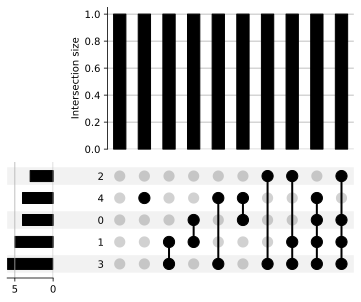

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from upsetplot import UpSet, plot, from_indicators
import matplotlib.pyplot as plt

# Sample data
# data = {
#     'A': [1, 1, 0, 1, 0, 1],
#     'B': [1, 0, 1, 1, 0, 1],
#     'C': [0, 1, 1, 0, 1, 0],
#     'D': [1, 1, 0, 0, 0, 0],
# }

data = create_indicator_matrix(sets, 10).T

# Creating a DataFrame
df = pd.DataFrame(data, dtype=bool)
UpSet(from_indicators(df), subset_size='count')


In [5]:
df

,0,1,2,3,4
0,True,True,False,False,False
1,False,False,False,False,True
2,False,True,False,True,False
3,True,False,False,False,True
4,False,True,True,True,False
5,False,False,False,False,False
6,True,True,False,True,True
7,True,True,True,True,False
8,False,False,True,True,False
9,False,False,False,True,True
